### Barebones Implementation of SIFT

In [82]:
import cv2 as cv
import numpy as np
import copy
from matplotlib import pyplot as plt
from utils import Splitter
import utils
import math

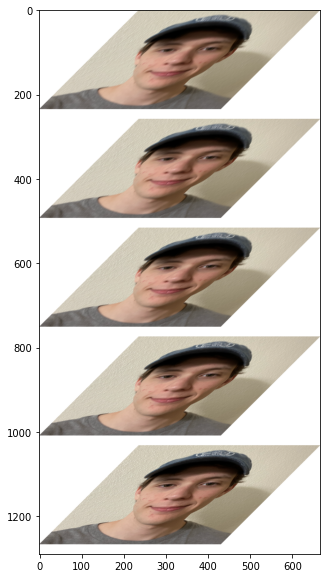

In [103]:
k = math.sqrt(2)
sigma = 1
src = cv.imread("me.PNG", cv.IMREAD_COLOR)
src = cv.cvtColor(src, cv.COLOR_BGR2RGB)
img = src.copy()
n_octaves = 4
oct_size = 5

octaves = []
for i in range(n_octaves):
    octave = utils.gen_octave(img, oct_size)
    img = cv.resize(img, (img.shape[0] // 2, img.shape[0] // 2))
    octaves.append(octave)

sample_oct_idx = 0
plt.figure(figsize=(10,10))
plt.imshow(utils.stack_imgs(octaves[sample_oct_idx]))

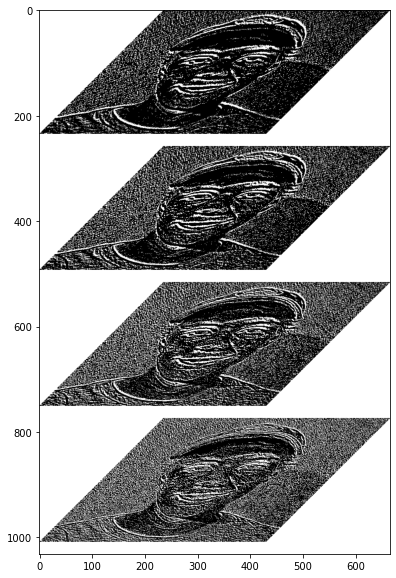

In [104]:
sample_octave = octaves[sample_oct_idx]
for i, scale in enumerate(sample_octave):
   sample_octave[i] = cv.cvtColor(scale, cv.COLOR_BGR2GRAY)

DoGs = []
for i in range(len(sample_octave ) - 1):
    sub_img = sample_octave[i + 1] - sample_octave[i]
    DoGs.append(sub_img)

plt.figure(figsize=(10,10))
stacked = utils.stack_imgs(DoGs)
plt.imshow(stacked, cmap = "gray")

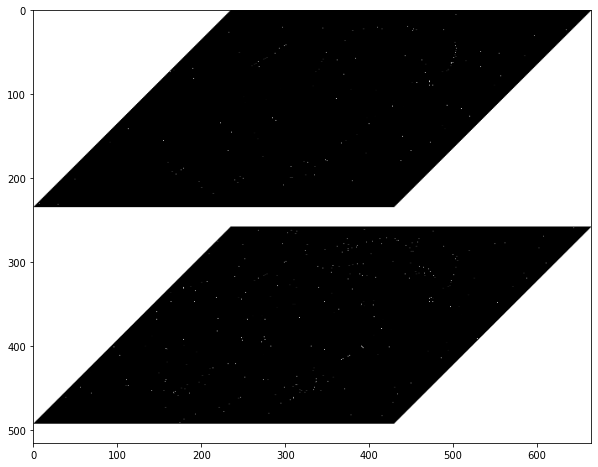

In [105]:
sample_scale_idx = 1
candidate1_map, candidates1 = utils.extrema_detection(DoGs, sample_scale_idx)
candidate2_map, candidates2 = utils.extrema_detection(DoGs, sample_scale_idx + 1)

plt.figure(figsize=(10,10))
stacked = utils.stack_imgs([candidate1_map, candidate2_map])
plt.imshow(stacked, cmap = "gray")

number of keypoints on sample before: 501


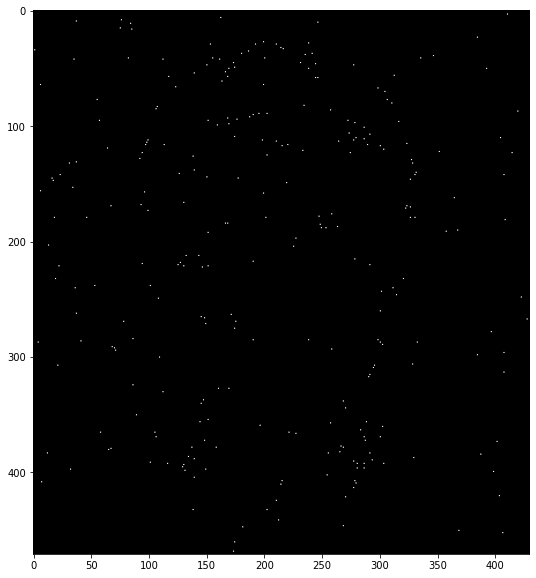

In [106]:
print(f"number of keypoints on sample before: {len(candidates1)}")

plt.figure(figsize=(10, 10))
plt.imshow(candidate1_map, cmap="gray")

number of keypoints on sample after refinement: 229


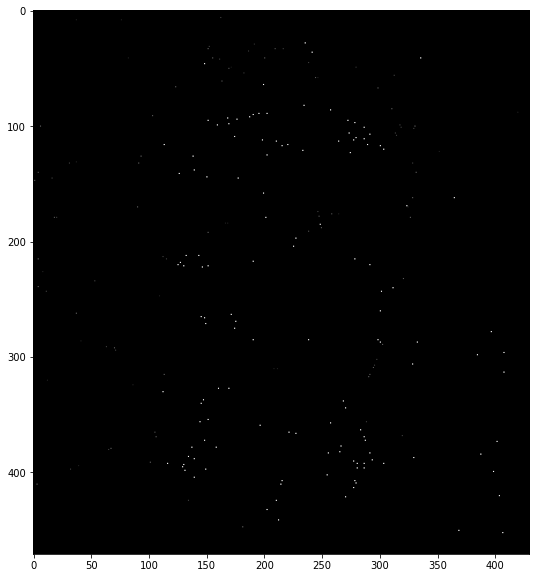

In [107]:
refined_map, refined1 = utils.keypoint_inter(DoGs, candidates1)
_, refined2 = utils.keypoint_inter(DoGs, candidates2)
print(f"number of keypoints on sample after refinement: {len(refined1)}")

plt.figure(figsize=(10, 10))
plt.imshow(refined_map, cmap="gray")

number of keypoints on sample after eliminating edge points: 218


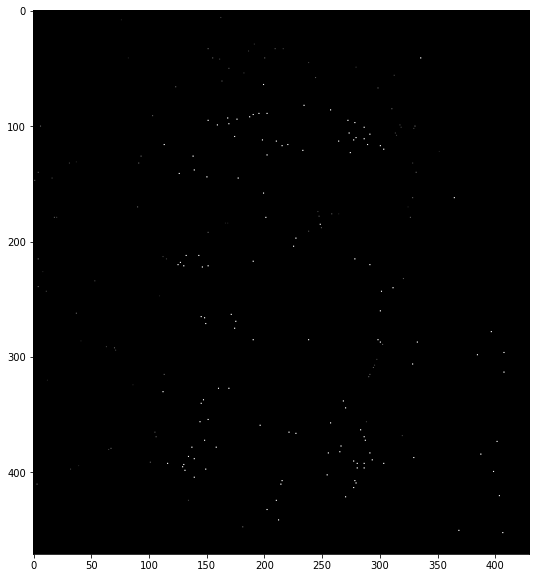

In [120]:
# They use r=10 in the original paper, 
# but for demonstration I chose a very extreme value
# you should use the default in practice

refined_map, keypoints1 = utils.elim_edge_responses(DoGs, refined1, r=10)
_, keypoints2 = utils.elim_edge_responses(DoGs, refined2, r=10)
print(f"number of keypoints on sample after eliminating edge points: {len(keypoints1)}")

plt.figure(figsize=(10, 10))
plt.imshow(refined_map, cmap="gray")

In [121]:
#  convert kps to absolute coordinates

def convert_keypoints(keypoints, o_idx, o_size, sigma):
    a_kps = []
    for (x, y, contrast, s_idx) in keypoints:
        # adjusted diameter of the neighborhood 
        sa = sigma * (2 ** (s_idx / float(o_size)))      
        # adjust the point
        pa = (x * (2 ** o_idx), y * (2 ** o_idx)) 
        kp = cv.KeyPoint(pa[0], pa[1], size=sa, response=contrast, octave=o_idx)
        a_kps.append(kp)
        
    return a_kps

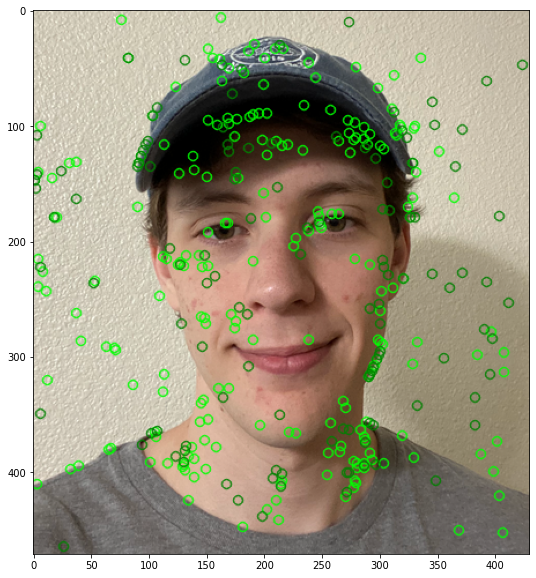

In [122]:
global_kps1 = convert_keypoints(keypoints1, sample_oct_idx, oct_size, sigma*k)
global_kps2 = convert_keypoints(keypoints2, sample_oct_idx, oct_size, sigma*k*k)
img_kp = src.copy()

for kp in global_kps1:
    pt = (int(kp.pt[0]), int(kp.pt[1]))
    cv.circle(img_kp, pt, 4, (0, 255, 0), 1, cv.LINE_AA)
for kp in global_kps2:
    pt = (int(kp.pt[0]), int(kp.pt[1]))
    cv.circle(img_kp, pt, 4, (1, 128, 0), 1, cv.LINE_AA)

plt.figure(figsize=(10, 10))
plt.imshow(img_kp)

In [156]:
def gen_hist(kp, scale, octave, o_idx):
    n_bins = 36 # bin for every 10 degrees in 360
    hist = np.zeros(n_bins)
    gauss_img = octave[int(kp.size)] / 255
    shape = gauss_img.shape
    rad = int(round(3 * scale))

    for y in range(-rad, rad + 1):
        y_r = int(round(kp.pt[1]) / float(2 ** o_idx)) + y
        if y_r < 1 or y_r >= shape[0] - 2:
            continue
        for x in range(-rad, rad + 1):
            x_r = int(round(kp.pt[0]) / float(2 ** o_idx)) + x
            if x_r < 1 or x_r >= shape[1] - 1:
                continue
            # compute magnitude and orientation
            dx = gauss_img[y_r, x_r + 1] - gauss_img[y_r, x_r - 1]
            dy = gauss_img[y_r + 1, x_r] - gauss_img[y_r - 1, x_r]
            mag = math.sqrt(dx ** 2 + dy ** 2)
            ori = np.rad2deg(np.arctan2(dy, dx))

            # compute sample contribution
            con = np.exp(-(x ** 2 + y ** 2) / (2 * scale ** 2))
            bin = int(round(ori * n_bins / 360.))
            hist[bin % n_bins] += con * mag
    
    return hist

def compute_orientations(keypoints, octaves, o_idx, k):
    descriptors = []
    octave = octaves[o_idx]
    peak = 0.8

    for kp in keypoints:
        scale = k * kp.size / (2 ** o_idx)
        hist = gen_hist(kp, scale, octave, o_idx)

    return descriptors

In [157]:
compute_orientations(global_kps2, octaves, sample_oct_idx, k)

[]